<a href="https://colab.research.google.com/github/fmuranda/Climate_Science./blob/main/Landsurface_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pystac planetary_computer rioxarray

In [4]:
import pystac
import planetary_computer
import rioxarray

item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LC09_L2SP_169073_20251030_02_T1"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)

signed_item = planetary_computer.sign(item)

# Open one of the data assets (other asset keys to use: 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'qa_pixel', 'qa_radsat', 'qa_aerosol')
asset_href = signed_item.assets["qa"].href
ds = rioxarray.open_rasterio(asset_href)
ds

<xarray.DataArray (band: 1, y: 7711, x: 7621)> Size: 118MB
[58765531 values with dtype=int16]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 62kB -1.962e+06 -1.962e+06 ... -2.194e+06
  * x            (x) float64 61kB 2.556e+05 2.556e+05 ... 4.842e+05 4.842e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -9999
    scale_factor:   1.0
    add_offset:     0.0

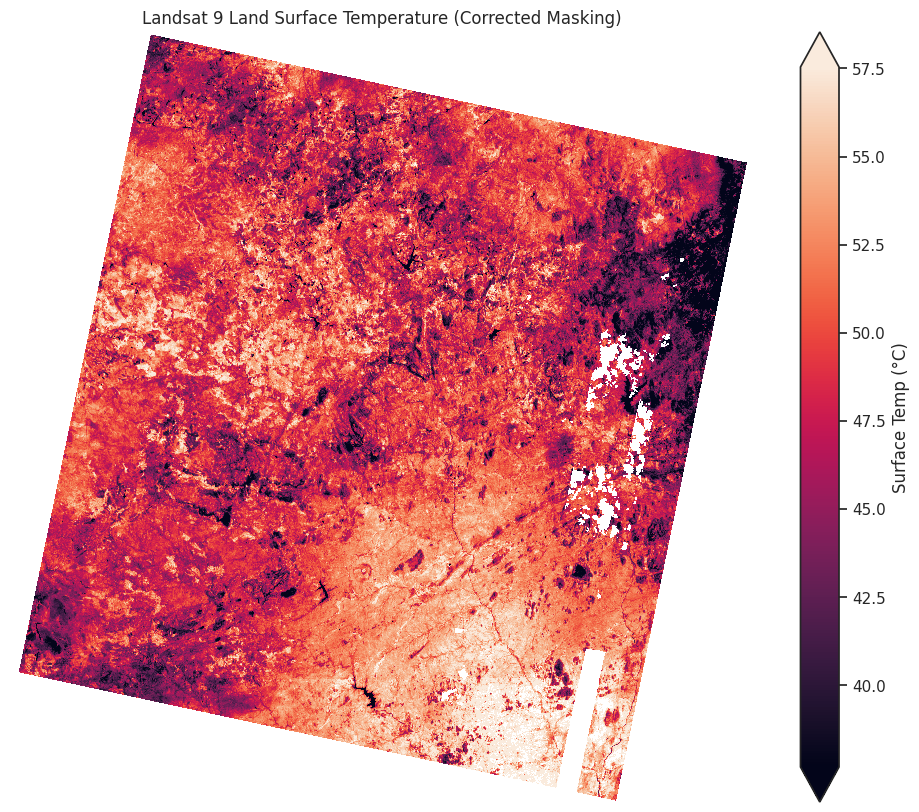

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load data and MASK NoData values immediately
# This is the most important step for a clean visual.
b10 = rioxarray.open_rasterio(signed_item.assets["lwir11"].href, masked=True).squeeze()
red = rioxarray.open_rasterio(signed_item.assets["red"].href, masked=True).squeeze()
nir = rioxarray.open_rasterio(signed_item.assets["nir08"].href, masked=True).squeeze()

# 2. Scale factors (Applied only to non-NaN pixels)
BT = b10 * 0.00341802 + 149.0
red_s = red * 0.0000275 - 0.2
nir_s = nir * 0.0000275 - 0.2

# 3. NDVI and Emissivity (Clipping prevents math errors on water/clouds)
ndvi = (nir_s - red_s) / (nir_s + red_s)
pv = ((ndvi.clip(0.2, 0.5) - 0.2) / (0.5 - 0.2))**2
emissivity = 0.004 * pv + 0.986

# 4. Single-Channel LST
lambda_val = 10.8
rho = 14388
lst_k = BT / (1 + (lambda_val * BT / rho) * np.log(emissivity))
lst_c = lst_k - 273.15

# 5. Filter out the "Absolute Zero" artifacts and extreme clouds
# We only want to see pixels between -10C and 60C (realistic land temps)
lst_final = lst_c.where((lst_c > -10) & (lst_c < 60))

# 6. Final Visualization with Seaborn 'rocket' palette
sns.set_theme(style="ticks")
plt.figure(figsize=(12, 10))

# 'rocket' is a great heat palette; 'robust=True' handles remaining outliers
plot = lst_final.plot(
    cmap="rocket",
    robust=True,
    cbar_kwargs={"label": "Surface Temp (°C)"}
)

plt.title("Landsat 9 Land Surface Temperature (Corrected Masking)")
plt.axis("off")
plt.show()

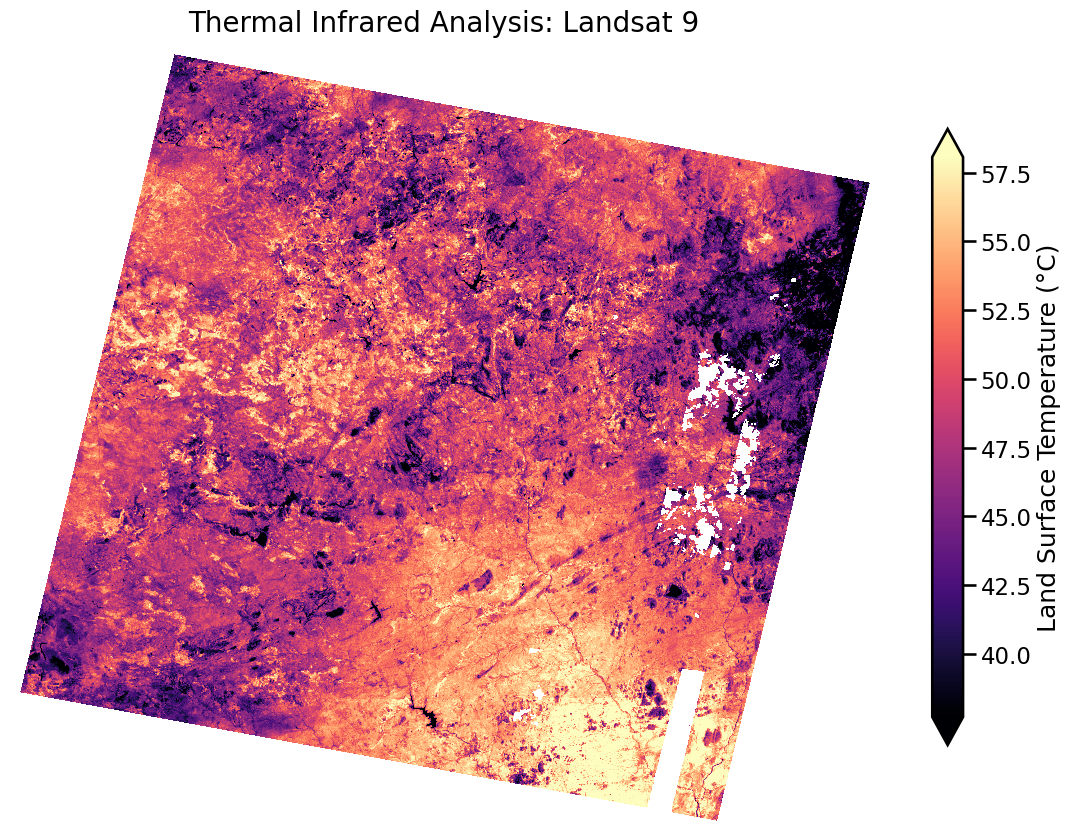

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rioxarray
import pystac
import planetary_computer

# 0. Initialize and sign the item (Fixes NameError: 'signed_item' is not defined)
item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LC09_L2SP_169073_20251030_02_T1"
item = pystac.Item.from_file(item_url)
signed_item = planetary_computer.sign(item)

# 1. Define LST calculation logic
b10 = rioxarray.open_rasterio(signed_item.assets["lwir11"].href, masked=True).squeeze()
red = rioxarray.open_rasterio(signed_item.assets["red"].href, masked=True).squeeze()
nir = rioxarray.open_rasterio(signed_item.assets["nir08"].href, masked=True).squeeze()

# Apply scale factors (Landsat 9 Collection 2 Level 2)
BT = b10 * 0.00341802 + 149.0
red_s = red * 0.0000275 - 0.2
nir_s = nir * 0.0000275 - 0.2

# Calculate NDVI and Emissivity
ndvi = (nir_s - red_s) / (nir_s + red_s)
pv = ((ndvi.clip(0.2, 0.5) - 0.2) / (0.5 - 0.2))**2
emissivity = 0.004 * pv + 0.986

# Single-Channel Land Surface Temperature Calculation
lambda_val = 10.8
rho = 14388
lst_k = BT / (1 + (lambda_val * BT / rho) * np.log(emissivity))
lst_c = lst_k - 273.15

# 2. Filter for high-quality visualization
lst_filtered = lst_c.where((lst_c > 0) & (lst_c < 70))

# 3. Set visual style and plot
sns.set_context("talk")
plt.figure(figsize=(14, 10))

plot = lst_filtered.plot(
    cmap="magma",
    robust=True,
    cbar_kwargs={
        "label": "Land Surface Temperature (°C)",
        "shrink": 0.8,
        "aspect": 20
    }
)

plt.title("Thermal Infrared Analysis: Landsat 9", fontsize=20, pad=15)
plt.axis("off")
plt.show()